# Demo: sequences <-> networks
The following notebook provides a demonstration how the ts2g2 library can be used to convert time series into graphs and graphs into time series. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN) and Apple stock (APPLE). All the column desinpiptions are provided. Currency is USD.

In [11]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from core import model
from input_output import input as inp
import from_graph.strategy_to_time_sequence as tts
import to_graph.strategy_linking_graph as gls
import to_graph.strategy_linking_multi_graphs as mgl
import to_graph.strategy_to_graph as tgs

import warnings
warnings.filterwarnings('ignore')

# Accessing data
We first get path to the data.

In [12]:
amazon_path = os.path.join(os.getcwd(), "tutorial_data", "AMZN.csv")
apple_path = os.path.join(os.getcwd(), "tutorial_data", "APPLE.csv")

# Converting time series to graph
Here are two examples of conversion of data from time serie to graph. Second one is inpeated using sliding window mechanism. That means its nodes are smaller graphs inpeated based on a segments of data (length = 5).

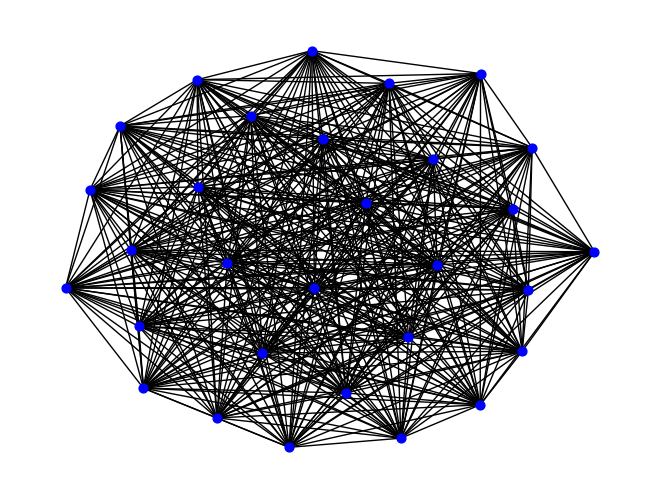

In [13]:
test = model.TimeseriesPreprocessingComposite(inp.CsvStock(amazon_path, "Close").from_csv())\
    .add_strategy(model.TimeseriesPreprocessingSegmentation(60, 90))\
    .process()\
    .to_graph(tgs.BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(gls.LinkNodesWithinGraph().by_value(gls.StrategyLinkingGraphByValueWithinRange(2)).seasonalities(15))\
    .draw("blue")


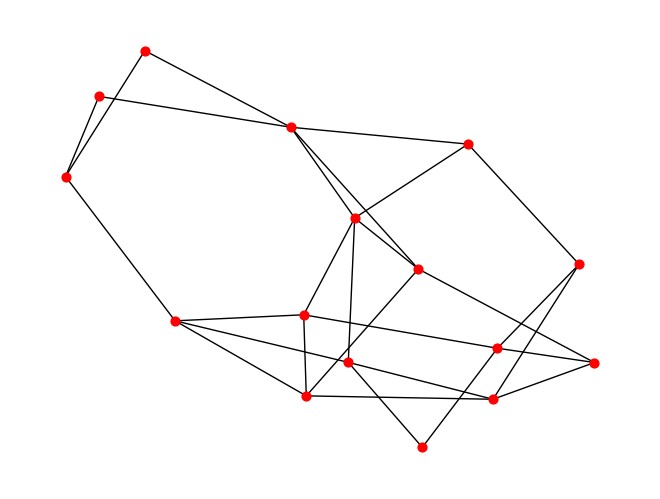

In [14]:
x = model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(model.TimeseriesPreprocessingSegmentation(60, 120))\
    .add_strategy(model.TimeseriesPreprocessingSlidingWindow(5))\
    .process()\
    .to_graph(tgs.BuildTimeseriesToGraphNaturalVisibilityStrategy().get_strategy())\
    .link(mgl.LinkGraphs().sliding_window())\
    .combine_identical_nodes_slid_win()\
    .draw("red")

# Combining multiple graphs
We can store and combine multiple of already inpeated objects TimeSeriesToGraph into one object MultivariateTimeSeriesToGraph

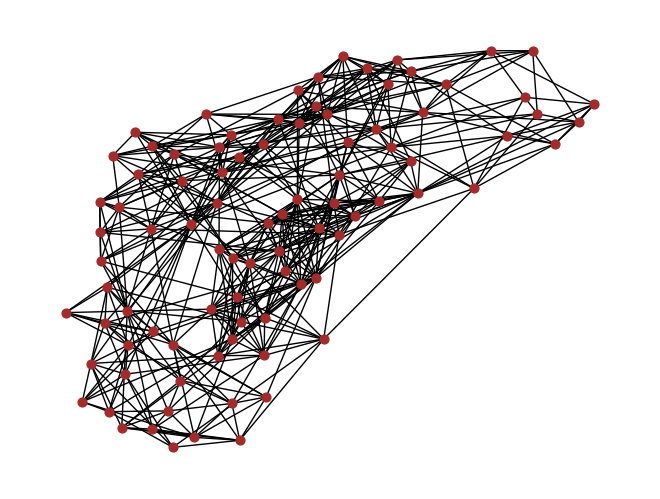

In [15]:
i = model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(model.TimeseriesPreprocessingSegmentation(60, 90))\
    .process()\
    .add(model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
        .add_strategy(model.TimeseriesPreprocessingSegmentation(90, 120))\
        .process())\
    .add(model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
        .add_strategy(model.TimeseriesPreprocessingSegmentation(150, 180))\
        .process())\
    .to_graph(tgs.BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .link(mgl.LinkGraphs().time_cooccurrence())\
    .link(gls.LinkNodesWithinGraph().by_value(gls.StrategyLinkingGraphByValueWithinRange(0.5)))\
    .combine_identical_nodes()\
    .draw("brown")

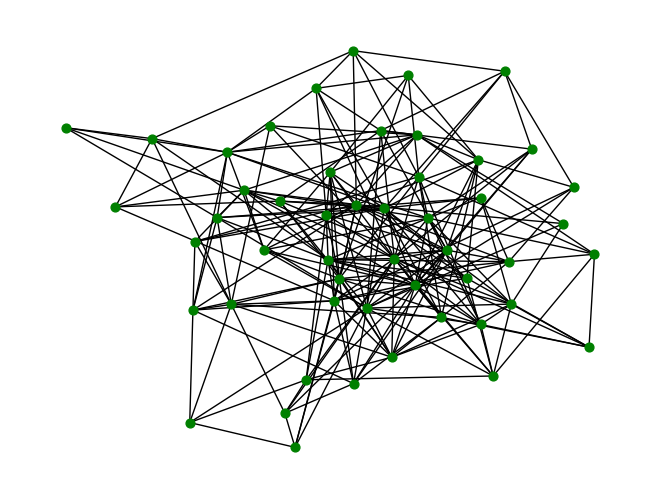

In [16]:
j = model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
    .add_strategy(model.TimeseriesPreprocessingSegmentation(60, 110))\
    .add_strategy(model.TimeseriesPreprocessingSlidingWindow(5))\
    .process()\
    .add(model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
         .add_strategy(model.TimeseriesPreprocessingSegmentation(90, 140))\
            .add_strategy(model.TimeseriesPreprocessingSlidingWindow(5))\
                .process()\
                .add(model.TimeseriesPreprocessingComposite(inp.CsvStock(apple_path, "Close").from_csv())\
                    .add_strategy(model.TimeseriesPreprocessingSegmentation(150, 200))\
                        .add_strategy(model.TimeseriesPreprocessingSlidingWindow(5))\
                            .process()))\
    .to_graph(tgs.BuildTimeseriesToGraphNaturalVisibilityStrategy().get_strategy())\
    .link(mgl.LinkGraphs().sliding_window().time_cooccurrence())\
    .combine_identical_nodes_slid_win()\
    .link(gls.LinkNodesWithinGraph().seasonalities(15))\
    .draw("green")

# Back to time series
We can convert existing graphs back to time series based on our strategy.

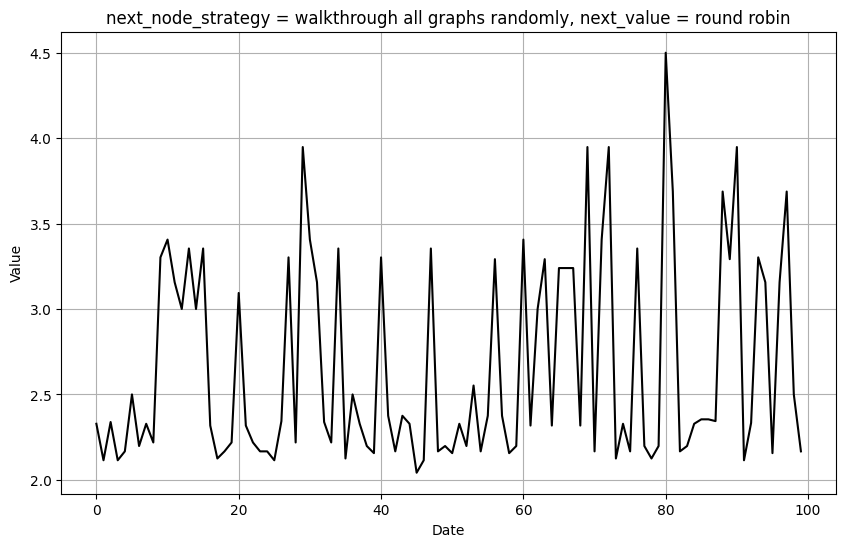

In [17]:
model.GraphToTS(test)\
    .next_node_strategy(tts.StrategySelectNectNodeRandomlyAcrossGraphs())\
    .next_value_strategy(tts.StrategyNextValueInNodeRoundRobin().skip_every_x_steps(1))\
    .ts_length(100)\
    .to_multiple_time_sequences()\
    .draw()

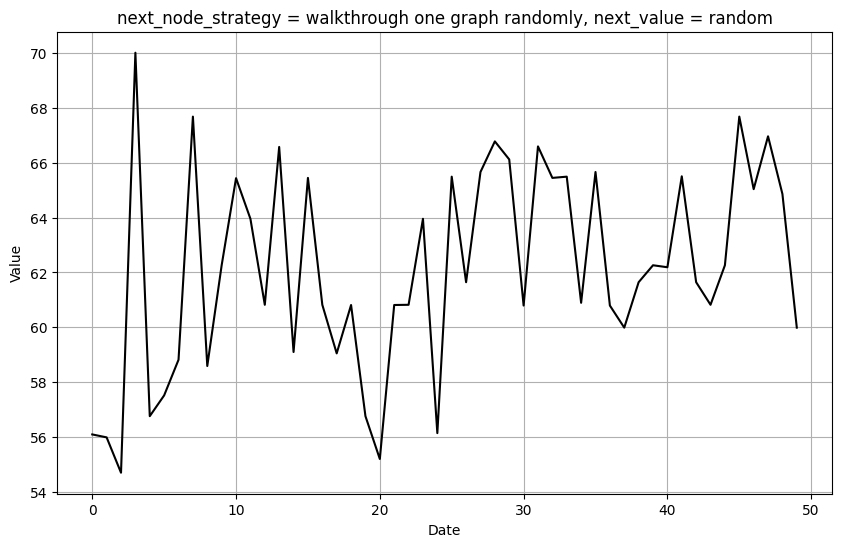

In [18]:
model.GraphSlidWin(x)\
    .next_node_strategy(tts.StrategySelectNextNodeRandomlyFromFirstGraph())\
    .next_value_strategy(tts.StrategyNextValueInNodeRandomForSlidingWindow().skip_every_x_steps(1))\
    .ts_length(50)\
    .to_time_sequence()\
    .draw()

We can also convert our multivriate graphs back to multiple time series.

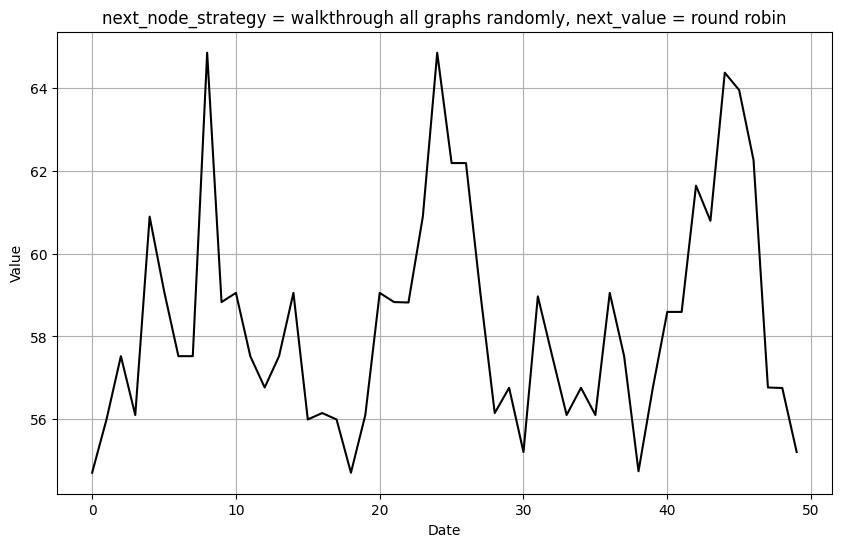

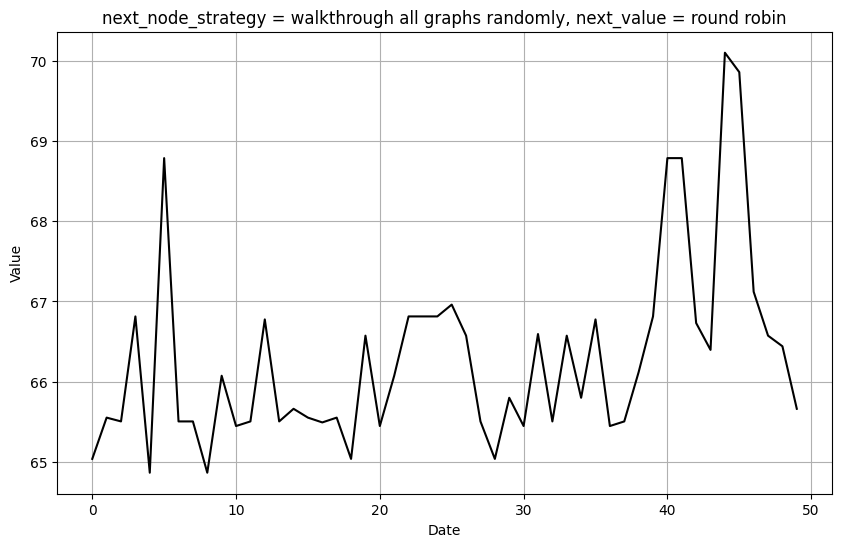

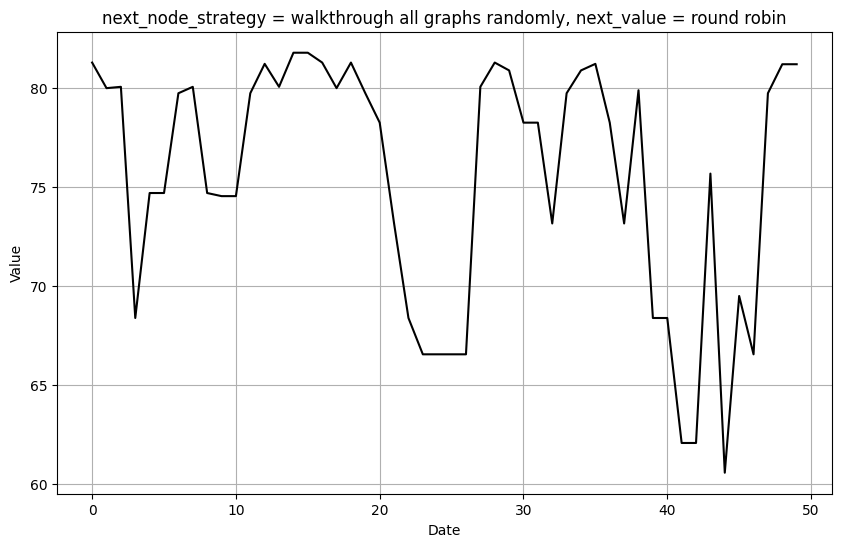

In [19]:
model.GraphToTS(i)\
    .next_node_strategy(tts.StrategySelectNectNodeRandomlyAcrossGraphs().change_graphs_every_x_steps(2))\
    .next_value_strategy(tts.StrategyNextValueInNodeRoundRobin().skip_every_x_steps(1))\
    .ts_length(50)\
    .to_multiple_time_sequences()\
    .draw()

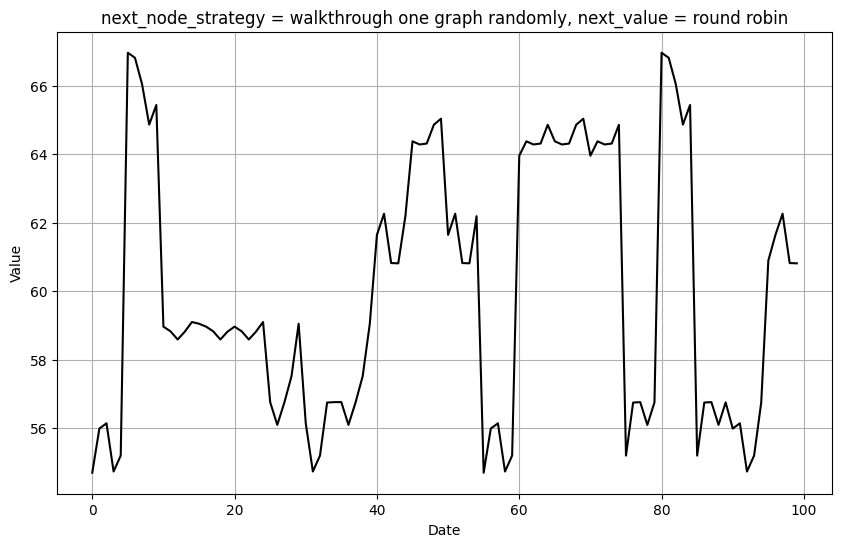

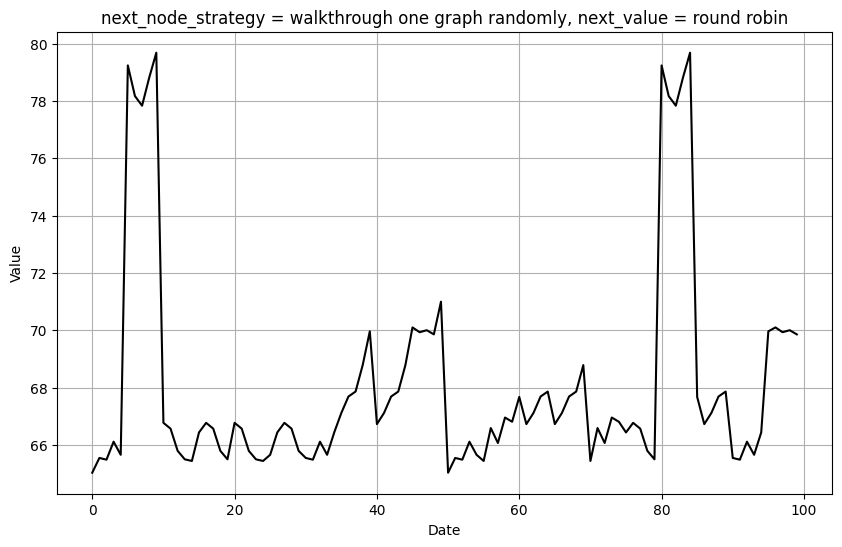

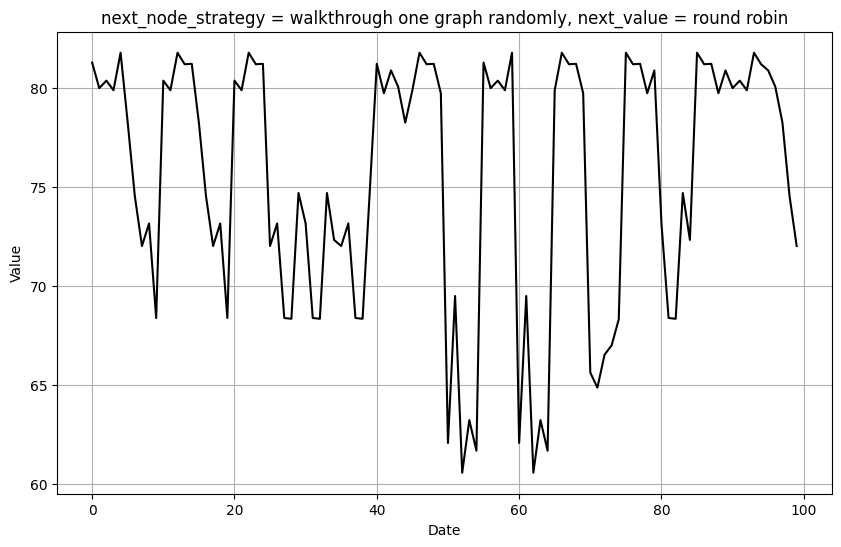

In [20]:
model.GraphSlidWin(j)\
    .next_node_strategy(tts.StrategySelectNextNodeRandomlyFromFirstGraph())\
    .next_value_strategy(tts.StrategyNextValueInNodeRoundRobinForSlidingWindow())\
    .ts_length(100)\
    .to_multiple_time_sequences()\
    .draw()